This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce     

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_lr1 as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_lr1 as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=1, help='number of embedding dimension [default: 1]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-8.4004)
args.L2 = np.exp(-6.1833)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
merged_set_f = [[set_y[i],model_x[i][:-1]] for i in range(len(set_y))] # added [:-1] to exclude last visit
merged_set =[x for x in merged_set_f if len(x[1])>0]
print(len(merged_set))
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print(test_sh_L[0])
print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])

35708

Loading and preparing data...

Sample data after split:
[0, [[4000, 2016, 244, 1022, 1348, 673, 4900, 127, 2799, 156, 212, 196, 158, 333, 74, 22, 23, 6, 808, 111, 7, 214, 190, 31, 34, 8, 192, 10, 43, 44, 48, 61, 62, 63]]]
model is LR
[0, [[3480, 109, 62, 85], [1724, 401, 3480, 109, 62, 85], [145, 432, 593, 1327, 57, 129, 3480, 109, 62, 85], [145, 432, 2929, 272, 119, 1089, 2419, 1724, 401, 3488, 673, 57, 277, 3480, 258, 886, 196, 158, 22, 550, 6, 189, 26, 111, 7, 308, 190, 31, 8, 10, 1120, 43, 173, 356, 357, 1102, 109, 62, 85]]]
[0, [[119, 454, 83, 62, 85], [2660, 119, 124, 83, 62, 85], [793, 475, 83, 62, 85], [475, 83, 62, 85], [475, 83, 62, 85], [475, 83, 62, 85]]]
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [773, 379, 62, 63, 1518, 665, 379, 62, 63, 665, 379, 62, 63, 1752, 319, 989, 665, 2448, 588, 379, 62, 63, 773, 379, 62, 63, 514, 503, 945, 244, 5085, 526, 773, 153, 3975, 12, 4

In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size, embed_dim =1)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

Parameter containing:
 9.4691e-02
-1.9577e+00
-6.7964e-01
     ⋮      
 7.3851e-01
-5.9416e-01
 1.7606e+00
[torch.FloatTensor of size 20000x1]

        emb                           types
0  0.094691                            Code
1 -1.957698  b'M_ACETAMINOPHEN-HYDROCODONE'
2 -0.679635         b'M_BACITRACIN TOPICAL'
3  0.626274    b'M_BUPIVACAINE-EPINEPHRINE'
4  0.528306                  b'M_CEFAZOLIN'


In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.4786885764518823


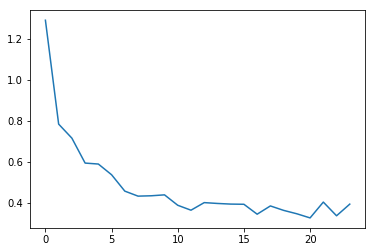

Epoch  0 Summary:  Training_auc : 0.591276099976565  , Validation_auc :  0.5832775119617225  ,Test_auc :  0.5994731331035492 Test_auc on short visits: 0.6131105158526455 Test_auc on long visits: 0.5985315211239213  Avg Loss:  0.4786885764518823 Train Time (0m 33s) Eval Time (0m 16s)

 Current running on: Epoch  1 Training loss:  Average loss 0.3495751612192641


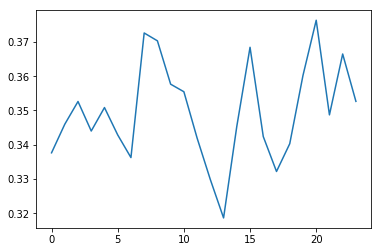

Epoch  1 Summary:  Training_auc : 0.6195343715806387  , Validation_auc :  0.6205535390199637  ,Test_auc :  0.6348008548176993 Test_auc on short visits: 0.6323231569024576 Test_auc on long visits: 0.639668571399035  Avg Loss:  0.3495751612192641 Train Time (0m 56s) Eval Time (0m 16s)

 Current running on: Epoch  2 Training loss:  Average loss 0.34589062644504365


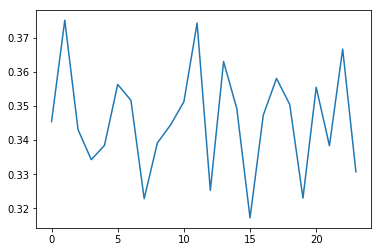

Epoch  2 Summary:  Training_auc : 0.642286770296862  , Validation_auc :  0.644998350107243  ,Test_auc :  0.6558866126116528 Test_auc on short visits: 0.6414989780013627 Test_auc on long visits: 0.6672073315397319  Avg Loss:  0.34589062644504365 Train Time (0m 31s) Eval Time (0m 16s)

 Current running on: Epoch  3 Training loss:  Average loss 0.34025452567267106


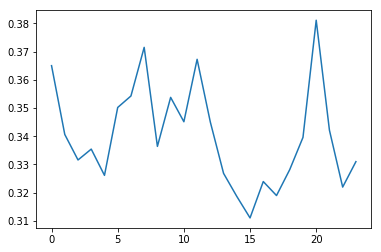

Epoch  3 Summary:  Training_auc : 0.677374937537991  , Validation_auc :  0.6803530770499917  ,Test_auc :  0.6847221823851976 Test_auc on short visits: 0.6675226099698534 Test_auc on long visits: 0.698912467597582  Avg Loss:  0.34025452567267106 Train Time (0m 36s) Eval Time (0m 20s)

 Current running on: Epoch  4 Training loss:  Average loss 0.33354735034415217


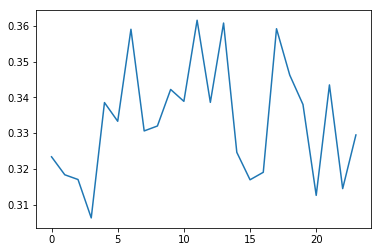

Epoch  4 Summary:  Training_auc : 0.7188472392278404  , Validation_auc :  0.7214535555188912  ,Test_auc :  0.7241701492503955 Test_auc on short visits: 0.7063515581979224 Test_auc on long visits: 0.7367820102292141  Avg Loss:  0.33354735034415217 Train Time (0m 43s) Eval Time (0m 24s)

 Current running on: Epoch  5 Training loss:  Average loss 0.3270029098151721


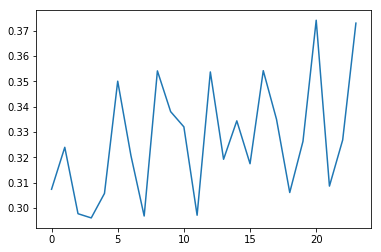

Epoch  5 Summary:  Training_auc : 0.753231894252743  , Validation_auc :  0.7564523180993236  ,Test_auc :  0.7523906250174611 Test_auc on short visits: 0.7412955116059846 Test_auc on long visits: 0.763009942341141  Avg Loss:  0.3270029098151721 Train Time (0m 46s) Eval Time (0m 23s)

 Current running on: Epoch  6 Training loss:  Average loss 0.321533100421829


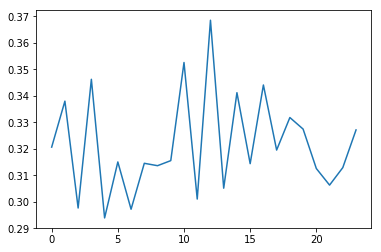

Epoch  6 Summary:  Training_auc : 0.7671954927621883  , Validation_auc :  0.7640356376835507  ,Test_auc :  0.7642136537645616 Test_auc on short visits: 0.7633606488524683 Test_auc on long visits: 0.7717572383706656  Avg Loss:  0.321533100421829 Train Time (0m 43s) Eval Time (0m 22s)

 Current running on: Epoch  7 Training loss:  Average loss 0.3166565243968857


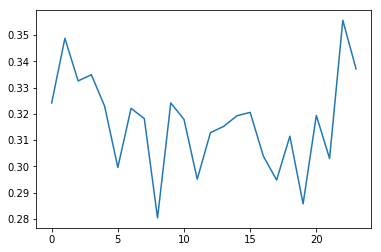

Epoch  7 Summary:  Training_auc : 0.7812990998726832  , Validation_auc :  0.7786767860089094  ,Test_auc :  0.7737677725383295 Test_auc on short visits: 0.7652028130629159 Test_auc on long visits: 0.7830124750924584  Avg Loss:  0.3166565243968857 Train Time (0m 43s) Eval Time (0m 24s)

 Current running on: Epoch  8 Training loss:  Average loss 0.31481417840802556


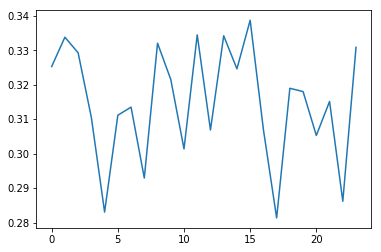

Epoch  8 Summary:  Training_auc : 0.7847303116440856  , Validation_auc :  0.7743581917175384  ,Test_auc :  0.7763625286780015 Test_auc on short visits: 0.7707013057315923 Test_auc on long visits: 0.7859194533392259  Avg Loss:  0.31481417840802556 Train Time (0m 43s) Eval Time (0m 24s)

 Current running on: Epoch  9 Training loss:  Average loss 0.31202736706490225


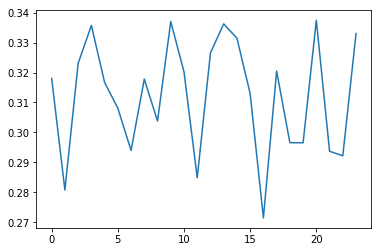

Epoch  9 Summary:  Training_auc : 0.7884600619892884  , Validation_auc :  0.777771819831711  ,Test_auc :  0.7740225639390452 Test_auc on short visits: 0.766527561296585 Test_auc on long visits: 0.7852146765185525  Avg Loss:  0.31202736706490225 Train Time (0m 41s) Eval Time (0m 22s)

 Current running on: Epoch  10 Training loss:  Average loss 0.31021429800712


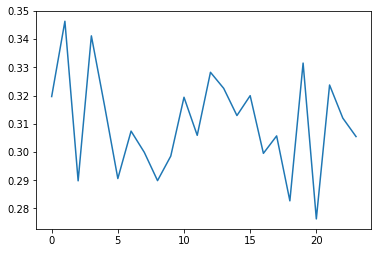

Epoch  10 Summary:  Training_auc : 0.7923162358944151  , Validation_auc :  0.7743276687015345  ,Test_auc :  0.7739085783124093 Test_auc on short visits: 0.7656543124609168 Test_auc on long visits: 0.7863203000018092  Avg Loss:  0.31021429800712 Train Time (0m 40s) Eval Time (0m 23s)

 Current running on: Epoch  11 Training loss:  Average loss 0.309508797781562


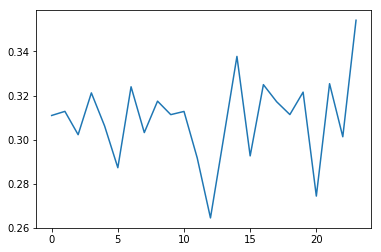

Epoch  11 Summary:  Training_auc : 0.7916992675231144  , Validation_auc :  0.7759726117802342  ,Test_auc :  0.7712652106554956 Test_auc on short visits: 0.7620650672465771 Test_auc on long visits: 0.782865162005629  Avg Loss:  0.309508797781562 Train Time (0m 43s) Eval Time (0m 24s)

 Current running on: Epoch  12 Training loss:  Average loss 0.3094598476910945


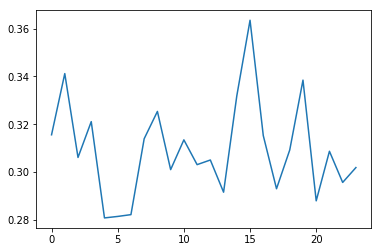

Epoch  12 Summary:  Training_auc : 0.7895792310724065  , Validation_auc :  0.7692006269592477  ,Test_auc :  0.7714871287504903 Test_auc on short visits: 0.7644829806893592 Test_auc on long visits: 0.7809020212906176  Avg Loss:  0.3094598476910945 Train Time (0m 43s) Eval Time (0m 23s)

 Current running on: Epoch  13 Training loss:  Average loss 0.3083524444517126


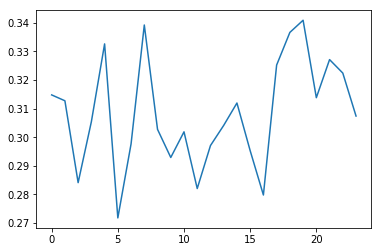

Epoch  13 Summary:  Training_auc : 0.7909301969461345  , Validation_auc :  0.7737807292525984  ,Test_auc :  0.7674610334920315 Test_auc on short visits: 0.7566972410703453 Test_auc on long visits: 0.7775412153588106  Avg Loss:  0.3083524444517126 Train Time (0m 43s) Eval Time (0m 24s)

 Current running on: Epoch  14 Training loss:  Average loss 0.3094293795555267


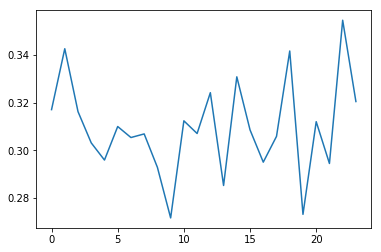

Epoch  14 Summary:  Training_auc : 0.7945361661678136  , Validation_auc :  0.7750156739811912  ,Test_auc :  0.7711569056850889 Test_auc on short visits: 0.7611148185135753 Test_auc on long visits: 0.7826010322253838  Avg Loss:  0.3094293795555267 Train Time (0m 44s) Eval Time (0m 23s)

 Current running on: Epoch  15 Training loss:  Average loss 0.30613901202588495


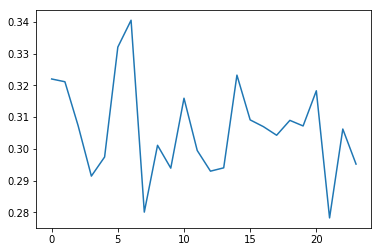

Epoch  15 Summary:  Training_auc : 0.7922353092532481  , Validation_auc :  0.7683220590661607  ,Test_auc :  0.7664002407853236 Test_auc on short visits: 0.7566453244729007 Test_auc on long visits: 0.7744378196629373  Avg Loss:  0.30613901202588495 Train Time (0m 43s) Eval Time (0m 24s)

 Current running on: Epoch  16 Training loss:  Average loss 0.3066120814557778


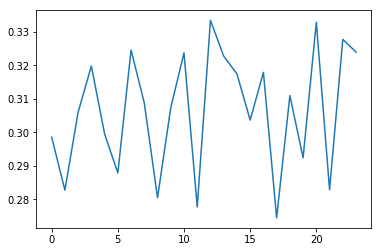

Epoch  16 Summary:  Training_auc : 0.784389939897703  , Validation_auc :  0.7592319749216301  ,Test_auc :  0.7567963929881705 Test_auc on short visits: 0.7535857452190065 Test_auc on long visits: 0.7628016364674839  Avg Loss:  0.3066120814557778 Train Time (0m 42s) Eval Time (0m 23s)

 Current running on: Epoch  17 Training loss:  Average loss 0.30752801376056976


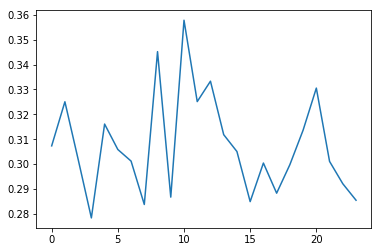

Epoch  17 Summary:  Training_auc : 0.7927900506790122  , Validation_auc :  0.7680960237584555  ,Test_auc :  0.7624449209159527 Test_auc on short visits: 0.7560847418870108 Test_auc on long visits: 0.7715825302185662  Avg Loss:  0.30752801376056976 Train Time (0m 46s) Eval Time (0m 29s)

 Current running on: Epoch  18 Training loss:  Average loss 0.30531622137347986


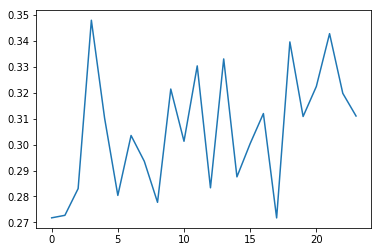

Epoch  18 Summary:  Training_auc : 0.7989074125301674  , Validation_auc :  0.7731281966672167  ,Test_auc :  0.7719204417576285 Test_auc on short visits: 0.757143490475346 Test_auc on long visits: 0.785135334206874  Avg Loss:  0.30531622137347986 Train Time (1m 11s) Eval Time (0m 23s)

 Current running on: Epoch  19 Training loss:  Average loss 0.3054966180678554


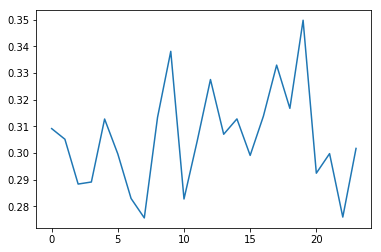

Epoch  19 Summary:  Training_auc : 0.7935410456941125  , Validation_auc :  0.7663463124896882  ,Test_auc :  0.7659185956374795 Test_auc on short visits: 0.7564026581297891 Test_auc on long visits: 0.7750658386120522  Avg Loss:  0.3054966180678554 Train Time (0m 42s) Eval Time (0m 23s)


In [9]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, _ = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
    #emb_wdf = pd.DataFrame(emb.weight)
    #emb_wdf.columns = ['emb_w']
    #print(emb_wdf.head())
    #emb_wdf.to_csv('embedding weight at Epoch'+str(ep), sep='\t')
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    #color1 = np.array([item for item in y_real])
    #plt.figure()
    #plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    #plt.show()
    #color2 = np.array([item for item in y_hat])
    #plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    #plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    #plt.show()

In [10]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

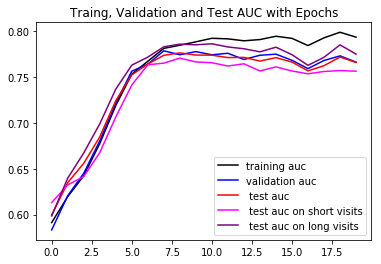

In [11]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [12]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_orignal_dim1_ExcLast')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

In [13]:
#extract weights
torch.save(ehr_model, 'Lr1model')
z= pd.DataFrame(ehr_model.embedding.weight.cpu().data.numpy())
z.to_csv('embedding weights_dim1_excludeLast')
ehr_model.embedding.weight

Parameter containing:
 3.2815e-14
 2.7545e-02
-2.9273e-42
     ⋮      
 3.5769e-07
 1.9735e-07
 5.1189e-14
[torch.cuda.FloatTensor of size 20000x1 (GPU 0)]